<a href="https://colab.research.google.com/github/tarod13/CardGames/blob/main/BlackJack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np
import random

In [92]:
def number2card(number):
  invalid_flag = False
  
  rank = (number % 13) + 1
  if rank < 1 or rank > 13:
    invalid_flag = True
  elif rank == 1:
    rank = 'A'
  elif rank == 11:
    rank = 'J'
  elif rank == 12:
    rank = 'Q'
  elif rank == 13:
    rank = 'K'
  else:
    rank = str(int(rank))
  
  symbol = number // 13
  if symbol == 0:
    symbol = 'clubs'
  elif symbol == 1:
    symbol = 'diamonds'
  elif symbol == 2:
    symbol = 'hearts'
  elif symbol == 3:
    symbol = 'spades'
  else:
    invalid_flag = True

  assert not invalid_flag, 'Invalid number'

  return (rank, symbol)


def card2value(card):
  rank = card[0]
  
  if rank == 'A':
    value = 1    
  elif rank in ['J', 'Q', 'K']:
    value = 10
  elif int(rank) > 1 and int(rank) <= 10:
    value = int(rank)
  else:
    print(rank)
    raise NameError('Invalid card')
  
  return value

In [193]:
def state2code(state):
  n_aces = 0
  sum_ = 0
  
  player_hand, dealer_card = state
  
  for card in player_hand:  
    rank = card[0]
    if rank == 'A':
      n_aces += 1          
    sum_ += card2value(card)
  
  visible_score_dealer = card2value(dealer_card)
  soft_hand = (21 - sum_) >= 10
  usable_ace = (n_aces > 0)  and soft_hand
  return (sum_, visible_score_dealer, usable_ace)


def sample_epsilon_policy(hand_sum, dealer_score, usable_ace, q_function, eps):
  q_values = q_function[int(hand_sum-12), int(dealer_score-1), int(usable_ace), :]
  if np.random.rand() > eps:
    possible_actions = q_values.argmax()
    if isinstance(possible_actions, np.int64):
      action_id = possible_actions
    else:
      action_id = random.choice(possible_actions)
  else:
    action_id = np.random.randint(0, high=N_acciones)
  if action_id == 0:
    return 'stand'
  else:
    return 'hit'

In [486]:
class BlackJackEnv():
  def __init__(self, seed=0):    
    self.seed(seed)
    
  def step(self, action):
    state = [list(self.player_hand).copy(), self.visible_dealer_card]

    if action == 0 or action == '0' or action == 'stand':
      sum_dealer, n_aces_dealer = self.calculate_sum(who='dealer')
      score_dealer = self.calculate_score(sum_dealer, n_aces_dealer)
      sum_player, n_aces_player = self.calculate_sum()
      score_player = self.calculate_score(sum_player, n_aces_player)
      
      if (score_player == 21) and (len(self.player_hand) == 2):
        if score_dealer == 21:
          reward = 0.0
        else:
          reward = 1.0
      else:
        while score_dealer < 17:
          new_dealer_card = set(random.sample(self.deck, 1))        
          self.deck = self.deck - new_dealer_card
          self.dealer_hand = self.dealer_hand.union(new_dealer_card)
          sum_dealer, n_aces_dealer = self.calculate_sum(who='dealer')
          score_dealer = self.calculate_score(sum_dealer, n_aces_dealer)
        
        went_bust = score_dealer > 21
        if went_bust or (score_player > score_dealer):
          reward = 1.0
        elif score_player == score_dealer:
          reward = 0.0
        else:
          reward = -1.0
        
      done = True      

    elif action == 1 or action == '1' or action == 'hit':
      new_player_card = set(random.sample(self.deck, 1))
      self.deck = self.deck - new_player_card
      self.player_hand = self.player_hand.union(new_player_card)
      sum_player, n_aces_player = self.calculate_sum()
      went_bust = sum_player > 21      
      if went_bust:
        reward = -1
        done = True        
      else:
        reward = 0
        done = False        

    else:
      raise NameError('Invalid action')
    
    if done:    
      next_state = [list(self.player_hand).copy(), list(self.dealer_hand).copy()]
    else:
      next_state = [list(self.player_hand).copy(), self.visible_dealer_card]
    return state, next_state, reward, done 

  def seed(self, seed=None):
    random.seed(seed)

  
  def reset(self):
    self.deck = set(range(0,52))
    self.deck = set([number2card(x) for x in self.deck])

    self.player_hand = set(random.sample(self.deck, 2))
    self.deck = self.deck - self.player_hand
    self.dealer_hand = set(random.sample(self.deck, 2))
    self.deck = self.deck - self.dealer_hand

    self.visible_dealer_card = list(self.dealer_hand)[0]
    state = [list(self.player_hand).copy(), self.visible_dealer_card]
    return state


  @staticmethod
  def calculate_score(sum_no_aces, n_aces):
    score = sum_no_aces
    soft_hand = (21 - sum_no_aces) >= 10
    at_least_one_ace = n_aces > 0
    if soft_hand and at_least_one_ace:
      score += 10
    return score

  
  def calculate_sum(self, who='player'):
    n_aces = 0
    sum_ = 0
    
    if who == 'player':
      hand = self.player_hand
    else:
      hand = self.dealer_hand
    
    for card in hand:  
      rank = card[0]
      if rank == 'A':
        n_aces += 1          
      sum_ += card2value(card)
    
    return sum_, n_aces

In [500]:
semilla = 0
juego = BlackJackEnv(seed=semilla)
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)
m, nm, r, d = juego.step('hit')
print('Nueva mano: ', nm)
print('Recompensa: ', r)
print('Juego terminado: ', d)
m, nm, r, d = juego.step('stand')
print('Nueva mano: ', nm)
print('Recompensa: ', r)
print('Juego terminado: ', d)

Mano inicial:  [[('A', 'spades'), ('5', 'hearts')], ('4', 'hearts')]
Nueva mano:  [[('A', 'spades'), ('5', 'hearts'), ('5', 'diamonds')], ('4', 'hearts')]
Recompensa:  0
Juego terminado:  False
Nueva mano:  [[('A', 'spades'), ('5', 'hearts'), ('5', 'diamonds')], [('4', 'hearts'), ('7', 'hearts'), ('5', 'spades'), ('10', 'diamonds')]]
Recompensa:  1.0
Juego terminado:  True


In [399]:
def entrenar_agente(funcion_q, juego, n_episodios, 
                    imprimir=False, imprimir_cada_ep=5000, inicializar=False):
  if inicializar:
    n_visitas = np.zeros((10,10,2,2))
    
  for episodio in range(0, n_episodios):
    terminado = False    
    trayectoria = []
    estado = juego.reset()

    while not terminado:
      suma_mano, puntaje_dealer, usable_ace = state2code(estado)
      if suma_mano < 12:
        accion = 'hit'
      else:
        if inicializar:
          if suma_mano < 20:
            accion = 'hit'
          else:
            accion = 'stand'
        else:  
          accion = sample_epsilon_policy(suma_mano, puntaje_dealer, usable_ace, funcion_q, eps=epsilon)
      _, siguiente_estado, recompensa, terminado = juego.step(accion)

      estado = siguiente_estado.copy()  
      trayectoria.append([suma_mano, puntaje_dealer, usable_ace, accion, recompensa, terminado])

    retorno = 0
    for i in range(0,len(trayectoria)):
      suma_mano, puntaje_dealer, usable_ace, accion, recompensa, terminado = trayectoria.pop()
      retorno = recompensa + beta * retorno

      if suma_mano >= 12:
        # Indices del estado
        s_0 = int(suma_mano-12)
        s_1 = int(puntaje_dealer-1)
        s_2 = int(usable_ace)

        # Indice de la accion
        if accion == 'hit':
          a = 1
        else:
          a = 0
        
        if inicializar:
          # Numero de veces que ha sido visitada la pareja estado-acccion ((s0,s1,s2), a) 
          n = n_visitas[s_0, s_1, s_2, a] + 1

          # Se actualiza el número de visitas
          n_visitas[s_0, s_1, s_2, a] = n
          coef = 1/n
        else:
          coef = alpha
        
        # Se actualiza la funcion de valor
        funcion_q[s_0, s_1, s_2, a] += coef * (retorno - funcion_q[s_0, s_1, s_2, a]) 
    
    if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
      print('Episodio: ' + str(episodio+1))

In [400]:
def evaluar_agente(funcion_q, juego, n_episodios, imprimir=False, ciclo=0):
  retornos = []
  for episodio in range(0, n_episodios):
    terminado = False
    retorno = 0
    estado = juego.reset()

    paso = 0
    while not terminado:
      suma_mano, puntaje_dealer, usable_ace = state2code(estado)
      if suma_mano < 12:
        accion = 'hit'
      else:
        accion = sample_epsilon_policy(suma_mano, puntaje_dealer, usable_ace, funcion_q, eps=epsilon)
      _, siguiente_estado, recompensa, terminado = juego.step(accion)
      retorno = retorno + (beta**paso) * recompensa
      estado = siguiente_estado.copy()
      paso += 1  
      
    retornos.append(retorno)
  retornos = np.array(retornos)
  retorno_promedio = retornos.mean()
  desviacion_retorno = retornos.std()
  if imprimir:
    print(('Ciclo: ' + str(ciclo) + ', Retorno esperado: {:.3f}'.format(
        retorno_promedio) + u"\u00B1" + '{:.3f}'.format(desviacion_retorno)))
  
  return retorno_promedio, desviacion_retorno

In [501]:
N_episodios_train = 5000
N_episodios_eval = 1000
N_ciclos = 1000
N_acciones = 2
epsilon = 1.0
min_epsilon = 0.01
decay_eps = 0.995
beta = 1.0
alpha = 0.003
imprimir_cada = 50

juego = BlackJackEnv(seed=semilla)
funcion_q = np.zeros((10,10,2,2))
np.random.seed(semilla)

In [506]:
# Gs = []
# sigmaGs = []
for ciclo in range(0, N_ciclos):
  entrenar_agente(funcion_q, juego, N_episodios_train)
  G, sigmaG = evaluar_agente(funcion_q, juego, N_episodios_eval,
                             imprimir=(ciclo % imprimir_cada) == 0, ciclo=ciclo+1)
  Gs.append(G)
  sigmaGs.append(sigmaG)
  epsilon = max(min_epsilon, epsilon * decay_eps)

Ciclo: 1, Retorno esperado: -0.139±0.949
Ciclo: 51, Retorno esperado: -0.054±0.952
Ciclo: 101, Retorno esperado: -0.113±0.945
Ciclo: 151, Retorno esperado: -0.136±0.947
Ciclo: 201, Retorno esperado: -0.053±0.959
Ciclo: 251, Retorno esperado: -0.102±0.961
Ciclo: 301, Retorno esperado: -0.058±0.948
Ciclo: 351, Retorno esperado: -0.137±0.942
Ciclo: 401, Retorno esperado: -0.097±0.953
Ciclo: 451, Retorno esperado: -0.076±0.949
Ciclo: 501, Retorno esperado: -0.116±0.949
Ciclo: 551, Retorno esperado: -0.118±0.944
Ciclo: 601, Retorno esperado: -0.099±0.954
Ciclo: 651, Retorno esperado: -0.101±0.950
Ciclo: 701, Retorno esperado: -0.126±0.953
Ciclo: 751, Retorno esperado: -0.102±0.956
Ciclo: 801, Retorno esperado: -0.131±0.942
Ciclo: 851, Retorno esperado: -0.033±0.953
Ciclo: 901, Retorno esperado: -0.040±0.962
Ciclo: 951, Retorno esperado: -0.098±0.952


In [368]:
import pickle

In [369]:
pickle.dump(funcion_q, open('q.pt', 'wb'))

In [232]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

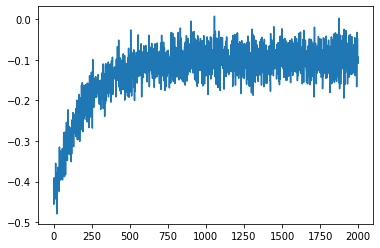

In [507]:
plt.plot(np.array(Gs))

In [508]:
optimal_policy = funcion_q.argmax(3)
opt_policy_df = {}
for i in range(0,2):
  opt_policy_df[str(i)] = pd.DataFrame(data=optimal_policy[:,:,i], 
                                       index=range(12,22), 
                                       columns=['A']+[str(x) for x in range(2,11)])

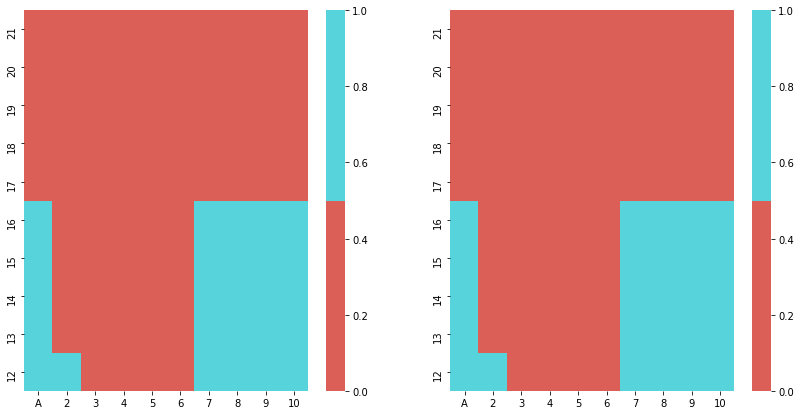

In [513]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
for i in range(0,2):
  sns_ax = sns.heatmap(opt_policy_df[str(i)], ax=ax[i], cmap=sns.color_palette("hls", 2))
  sns_ax.invert_yaxis()
plt.show()
plt.close()

In [498]:
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)

Mano inicial:  [[('A', 'spades'), ('Q', 'spades')], ('2', 'hearts')]


In [497]:
m, nm, r, d = juego.step('hit')
print('Nueva mano: ', nm)
print('Recompensa: ', r)
print('Juego terminado: ', d)

Nueva mano:  [[('K', 'hearts'), ('A', 'diamonds'), ('K', 'diamonds'), ('3', 'diamonds')], [('J', 'spades'), ('10', 'diamonds')]]
Recompensa:  -1
Juego terminado:  True


In [499]:
m, nm, r, d = juego.step('stand')
print('Nueva mano: ', nm)
print('Recompensa: ', r)
print('Juego terminado: ', d)

Nueva mano:  [[('A', 'spades'), ('Q', 'spades')], [('2', 'hearts'), ('9', 'diamonds')]]
Recompensa:  1.0
Juego terminado:  True


In [394]:
su, ac = juego.calculate_sum(who='dealer')
sc = juego.calculate_score(su, ac)
less_than_17 = (su + int(ac>0) * 10) < 17   
more_than_21 = su > 21

In [511]:
funcion_q[:,:,0,0]-funcion_q[:,:,1,0]

array([[-8.86713824e-02, -1.04372180e-02, -8.34972633e-02,
        -4.40266695e-02, -1.66233417e-02, -5.40176283e-02,
        -5.20206100e-02, -1.78959566e-02, -6.85023536e-02,
        -2.82116243e-02],
       [ 3.49876450e-02,  6.56085157e-02, -9.83260860e-03,
         2.12900566e-02,  5.34033343e-02, -3.45694850e-02,
        -1.25225584e-02,  2.72008511e-02, -1.91833655e-02,
        -4.18643381e-02],
       [-9.94469849e-02, -7.43889114e-02,  1.53453839e-02,
        -7.71145128e-02, -1.03035235e-02, -5.06059409e-02,
        -3.22818734e-02,  1.37128310e-02, -2.41797616e-02,
        -2.07221346e-02],
       [-1.67877121e-02, -4.53433673e-03, -1.37473902e-01,
         1.24656746e-02, -3.24703449e-02, -6.53492479e-02,
        -3.85450575e-02, -1.53938814e-02, -9.28702839e-02,
        -3.83896376e-02],
       [-1.34070816e-02,  2.25376660e-02, -2.51610546e-03,
        -6.42298649e-03, -9.14873573e-02, -3.63090796e-02,
         3.02959367e-02, -9.42255212e-02,  4.60149380e-05,
         1.